# Advanced and Uncommon HARK Concepts

The "Gentle Introduction to HARK" and other notebooks *mostly* focused on the most important features that a new user would want to be familiar with. But HARK has a *lot* more options and deeper structure, and this notebook describes some of those "advanced" topics.

## Measuring Up: Distance in HARK

In heterogeneous agents macroeconomics, we are often interested in infinite horizon models. Such models are usually solved by "finite horizon approximation": iteratively solving backward one period at a time until consecutive solutions are sufficiently close together that we conclude the process has converged. When using Bellman value functions, this logic relies on the fact that the Bellman operator is a contraction mapping.

But what does it mean to be "sufficiently close"? What are we even comparing when we talk about the "distance" between two candidate solutions? It depends on the context, and so HARK has a system for easily identifying "what matters" when calculating the distance between two abstract objects.

Particularly, all classes in HARK that could reasonably be part of the representation of a model solution inherit from the superclass `HARK.metric.MetricObject`. Essentially all this class does is provide a "universal distance metric" with simple customization.

The *only* think that a subclass of `MetricObject` needs to specify is a class attribute called `distance_criteria`, which must be a list of strings. Each element of `distance_criteria` names an attribute of that class that should be compared if HARK is ever asked to compare two instances of that class.

HARK's universal distance metric is nothing more than a "recursive supremum norm". That is, it returns the *highest* value among element-wise distances. Its logic to compare $A$ and $B$ is straightforward and obvious:

- if $A$ and $B$ are both numbers, their distance is the absolute value of their difference
- if $A$ and $B$ are both lists, then:
  - if the lists have the same length, their distance is the maximum distance between corresponding elements
  - otherwise, the distance is the difference in their lengths
- if $A$ and $B$ are both `numpy.array`, then:
  - if the arrays have the same shape, then the distance is the absolute value of the maximum difference between corresponding elements
  - if the arrays have different numbers of dimensions, return 10000 times the difference in cardinality
  - else return the sum of absolute differences in size in each dimension
- if $A$ and $B$ are both dictionaries, then:
  - if they both have `distance_criteria` entries that match, their distance is the maximum distance among keys named in distance criteria
  - else if they have the same keys, their distance is the maximum distance among their entries
  - otherwise, their distance is 1000, a large number
- if $A$ and $B$ are objects of the same class, and neither is a lambda function, then their distance is given by their `distance` method
- otherwise, the distance is 1000 because the objects cannot be meaningfully compared

As long as you are coding with `MetricObject` subclasses (like the interpolators in `HARK.interpolation`) and standard numeric Python objects, the distance metric will always succeed in comparing objects.

Note that comparing "incomparable" objects, like arrays of different shapes, will return a somewhat arbitrary "large" number (not near zero). This is because the sole purpose of measuring "distance" in HARK is to evaluate whether two solutions are sufficiently close. The tolerance level for such operations is usually on the order of $10^{-4}$ to $10^{-8}$, not $10$ or $1000$. That is, those "error code distances" mostly serve to ensure that a convergence criteria will *definitely* not be met when the comparitors are incomparable.

The tolerance for convergence is stored in the `tolerance` attribute of `AgentType` instances. It has a default of $10^{-6}$ but can be freely changed.

HARK only compares solutions from *consecutive* iterations when solving an infinite horizon model. In the future, we might add extended options to (say) compare a new solution to the one $N$ periods prior.

## Uncommon Options When Solving Models

The `solve()` method is usually called without any arguments, but there are a few options you can specify.

### Tell Me More, Tell Me More: `verbose`

First, passing `verbose=True` (or just `True`, because it is the first argument) when solving an infinite horizon model (`cycles=0`) will print solution progress to screen. This can be useful when developing a new model, if you want to know how long iterations take and how the solver is doing with respect to convergence.

In [1]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [2]:
VerboseType = IndShockConsumerType(cycles=0)
VerboseType.solve(True)

Finished cycle #1 in 0.0010004043579101562 seconds, solution distance = 100.0
Finished cycle #2 in 0.0010006427764892578 seconds, solution distance = 10.088015890333441
Finished cycle #3 in 0.0009999275207519531 seconds, solution distance = 3.3534114736589693
Finished cycle #4 in 0.0009996891021728516 seconds, solution distance = 1.6699529613894297
Finished cycle #5 in 0.0010008811950683594 seconds, solution distance = 0.9967360674688521
Finished cycle #6 in 0.0010001659393310547 seconds, solution distance = 0.6602619046109499
Finished cycle #7 in 0.0009999275207519531 seconds, solution distance = 0.46809484231437626
Finished cycle #8 in 0.0010004043579101562 seconds, solution distance = 0.34807706501006663
Finished cycle #9 in 0.0010008811950683594 seconds, solution distance = 0.2681341538834978
Finished cycle #10 in 0.0010001659393310547 seconds, solution distance = 0.21223248168627507
Finished cycle #11 in 0.0010089874267578125 seconds, solution distance = 0.17162798586899441
Finish

Notice that the solver terminated as soon as the distance went below $10^{-6}$, the default value for `tolerance`.

### Turning Off `pre_solve` and `post_solve`

When `solve()` is invoked, the `AgentType` instance usually runs their `pre_solve()` method before jumping into the main solver loop over periods. In some situations, the user might want to *skip* the call to `pre_solve()`-- maybe it would undo some unusual work that the user wants in place. To do so, simply pass `presolve=False` in the call to `solve()`.

Likewise, *after* the solution loop has completed its work, just before exiting the call to `solve()`, HARK runs the `post_solve()` method for that `AgentType` subclass. In the unusual situation in which a user does *not* want that method run, just pass `postsolve=False` to `solve()`.

### Take It From the Middle: `from_solution` and `from_t`

HARK's default behavior is to solve all model periods, starting from `solution_terminal` and working back to the very first period. A user can override this with two interrelated options.

In case of some *custom* terminal solution (or continuation solution), the solution object can be passed in the `from_solution` argument. One use case for this is solving an infinite horizon model by starting from the solution to a "nearby" model, rather than from the proper terminal period.

Likewise, the `from_t` optional argument can be used to indicate which time index to *actually* start the solver from. This option is *only* compatible with `cycles=1`. In conjunction with `from_solution`, this can be used to (say) impose some terminal solution in the *middle* of the life-cycle, and only solve the problem from that point backward. That terminal solution *might* be the first period of some *other* model for a "later phase" of life.

If you pass an argument for `from_t` but not `from_solution`, then HARK will use `solution_terminal` as the succeeding solution when trying to solve the one-period problem at time index `from_t`.

## Utility Functions

Utility functions and related objects can be imported from `HARK.rewards`. These functions used to be in `HARK.utilities`, but we decided that it was too confusing to have both "utility functions" and "utility tools" in the same file.

Almost all consumption-saving models in HARK use constant absolute risk aversion (CRRA) utility functions over consumption. There are two main ways to use CRRA utility from `HARK.rewards`.

### In-Line Utility Functions

First, there are individual functions like `CRRAutility` and `CRRAutilityP` that take in a (possibly vector-valued) consumption argument and a CRRA coefficient. They do exactly what you'd expect, and are programmed to correctly handle $\rho=1$ being log utility.

In most circumstances, it's convenient to locally define the (marginal) utility function for the currently relevant value of $\rho$.

In [3]:
from HARK.rewards import CRRAutility, CRRAutilityP, UtilityFuncCRRA
import matplotlib.pyplot as plt
from HARK.utilities import plot_funcs

In [4]:
rho = 2.5  # maybe this parameter was passed from elsewhere
u = lambda x: CRRAutility(x, rho)
uP = lambda x: CRRAutilityP(x, rho)

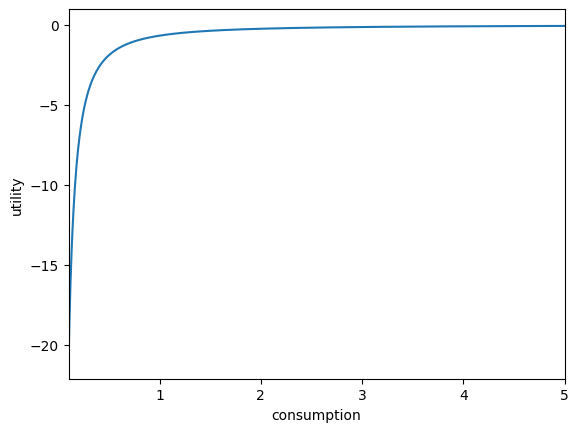

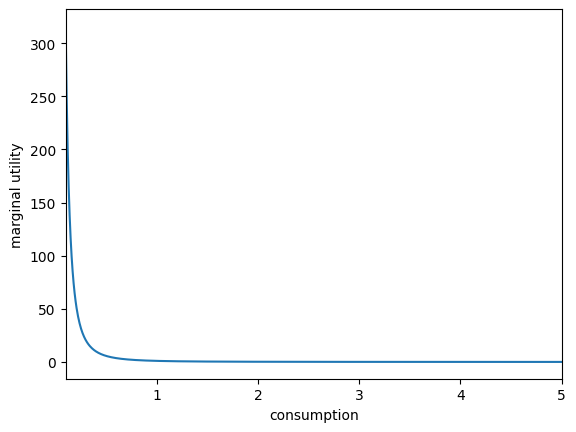

In [5]:
plt.xlabel("consumption")
plt.ylabel("utility")
plot_funcs(u, 0.1, 5.0)
plt.xlabel("consumption")
plt.ylabel("marginal utility")
plot_funcs(uP, 0.1, 5)

As a notational convention, HARK uses a capital `P` to denote "prime", and `_inv` for "inverse". `HARK.rewards` defines several layers of derivative and inverses for CRRA utility:

- `CRRAutility` : utility function
- `CRRAutilityP` : marginal utility function
- `CRRAutilityPP` : marginal marginal utility function
- `CRRAutilityPPP` : marginal marginal marginal utility function
- `CRRAutilityPPPP` : marginal marginal marginal marginal utility function
- `CRRAutility_inv` : inverse utility function
- `CRRAutilityP_inv` : inverse marginal utility function
- `CRRAutility_invP` : marginal inverse utility function
- `CRRAutilityP_invP` : marginal inverse marginal utility function

### Utility Function Structure

The second way to use CRRA utility is to simply import the class `UtilityFuncCRRA` and instantiate it with a single argument for $\rho$. This object then represents the utility function and *all* of its derivatives and inverses. Let's see an example.

In [6]:
U = UtilityFuncCRRA(2.0)  # CRRA utility function with rho=2

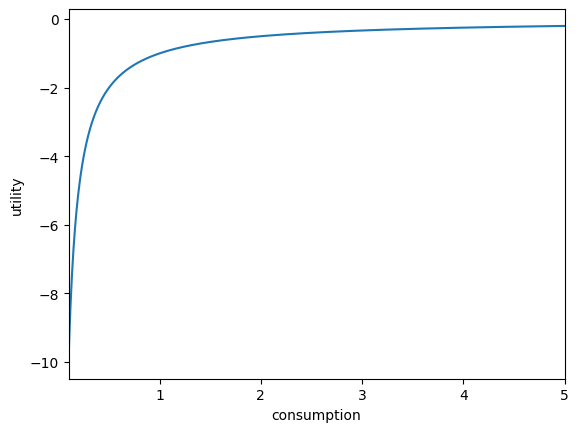

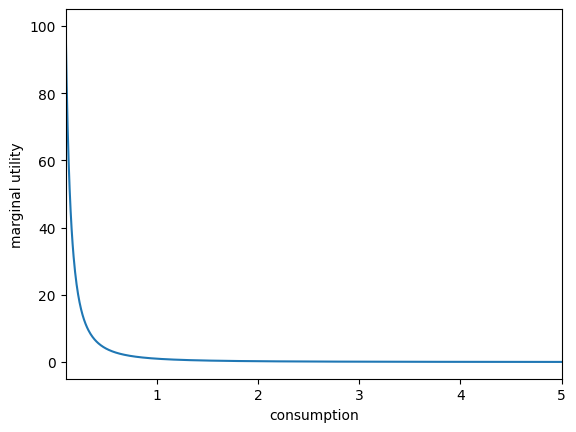

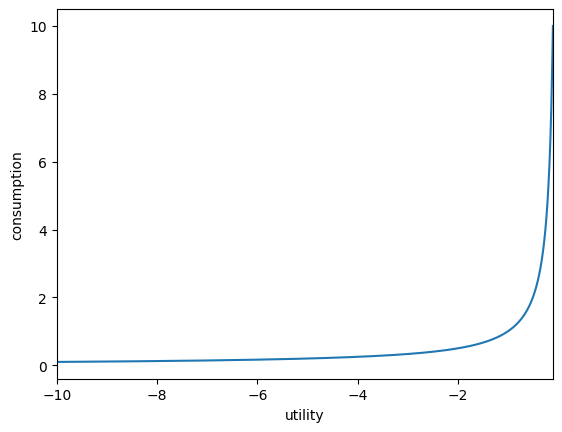

In [7]:
plt.xlabel("consumption")
plt.ylabel("utility")
plot_funcs(U, 0.1, 5.0)  # treat it like a function
plt.xlabel("consumption")
plt.ylabel("marginal utility")
plot_funcs(U.derivative, 0.1, 5)  # use its derivative method for marginal utility
plt.xlabel("utility")
plt.ylabel("consumption")
plot_funcs(U.inverse, -10.0, -0.1)  # use its inverse method

The `derivative` method accepts a second optional argument of `order` with a default of 1, indicating the order of the derivative (first to fourth order).

The `inverse` method also accepts an `order` argument as an ordered pair `(0,0)` to `(1,1)`. For a simple mnemonic, `order` refers to the number of `P`s in the function `CRRAutility[#1]_inv[#2]`. The default is `(0,0)`, which is just the inverse of utility.

### Other Utility Functions in `HARK.rewards`

Four other utility functions have various levels of support in HARK, but are rarely used:

- **Stone-Geary:** Modified CRRA utility of the form $U(c) = b \frac{(c+a)^{1-\rho}}{1-\rho}$, with a default of $b=1$.
- **Constant Absolute Risk Aversion (CARA):** Normalized exponential utility of the form $U(c) = 1 - \exp(-\alpha c) / \alpha$.
- **Cobb-Douglas:** Cobb-Douglas aggregator for an aribtrary number of goods: $U(x) = \prod_{j=1}^J x_j^{\zeta_j}$.
- **Constant Elastisticity of Substitution (CES)**: CES aggregator characterized by elasticity $\epsilon$, shares $\zeta$, scaling factor $\alpha$ and homogeneity degree $\eta$: $U(x) = \alpha \left(\prod_{j=1}^J \zeta_j x_j^\epsilon \right)^{\eta / \epsilon}$.

Each of these utility forms has a utility function class, but the inverse methods are not defined for multiple-input forms.

## Representing Distributions

The `HARK.distributions` module provides a fairly wide array of representations of distributions for random variables.

### Basics of Distributions in HARK

All distribution classes have some common methods and attributes:

- `seed` : An integer attribute that can be set at instantiation. It is used as the seed for the distribution's internal random number generator.
- `random_seed()` : A method to draw a *new* random seed for the distribution. This is not recommended for computations that need to be precisely replicated.
- `reset()` : A method to reset the distribution's internal RNG by using its own stored `seed`.
- `draw(N)` : A method to generate $N$ random draws from the distribution.
- `discretize(N, method)` : A method to generate a `DiscreteDistribution` based on this distribution object. The only universally required input is $N$, the number of nodes in the discretization, but a string `method` can be passed as well, along with method-specific `kwds`.
- `infimum` : The greatest lower bound for the support of the distribution; it is always an array, even for univariate distributions.
- `supremum` : The least upper bound for the support of the distribution; it is always an array.

### Our Workhorse: `DiscreteDistribution`

*Almost* all computation in HARK actually uses *discretized* approximations of continuous RVs. The default discretization method is `equiprobable` (which actually has options for *non*-equiprobable discretizations in some cases), rather than Gaussian methods. This approach is meant to ensure that the *mean* of the distribution is exactly preserved by the discretization.

The key attributes of a `DiscreteDistribution` are `pmv` and `atoms`. The `pmv` is the *probability mass vector*, a `np.array` that should sum to 1, representing the probability masses for each of the nodes.

The discretized nodes are stored in the `atoms` attribute as a 2D `np.array`, even for univariate distributions. The first dimension (`axis=0`) indexes multiple components of a multivariate distribution, and the second dimension (`axis=1`) index the nodes.

A `DiscreteDistribution` that is created from a continuous distribution object using its `discretize` method should have an attribute called `limit` with information about how it was generated:

- `dist` : a reference to the continuous distribution itself
- `method` : the name of the method that was used to build the approximation
- `N` : the number of nodes requested
- `infimum` : the infimum of the continuous distribution from which it was made
- `supremum` : the supremum of the continuous distribution from which it was made

We included this so that HARK's solvers can use (particularly) information about the "best" and "worst" things that can happen, even if they don't appear in the discretization. This is sometimes important for bounding behavior of the model solution.

### Say My Name: `DiscreteDistributionLabeled`

The default behavior in HARK is for multivariate distributions to simply be indexed by number. E.g. a joint distribution of permanent and transitory income shocks might have $\psi$ at index 0 and $\theta$ at index 1. However, we also have an extended class called `DiscreteDistributionLabeled` that allows more information to be provided.

The additional fields for a `Labeled` distribution are (all optional):

- `name` : a name or title for the distribution, for describing its purpose
- `attrs` : a dictionary of attributes, for arbitrary use
- `var_names` : a list of strings naming each variable in the distribution
- `var_attrs` : a list of dictionaries with attributes for each variable in the distribution

A `DiscreteDistributionLabeled` can be instantiated in two ways:

1) Passing a `pmv`, `atoms`, and `seed` along with any of the optional arguments, generating a completely new object.
2) Passing a `DiscreteDistribution` along with any optional arguments, effectively "converting" the input distribution.

### Example Usage

We won't show *everything* in `HARK.distribution` here, but this is a sampling (no pun intended) of some key features.

In [8]:
import numpy as np
from HARK.distributions import (
    Lognormal,
    add_discrete_outcome,
    add_discrete_outcome_constant_mean,
    DiscreteDistributionLabeled,
    expected,
)

In [9]:
# Make a lognormal distribution and draw twenty numbers from it
F = Lognormal(mu=0.2, sigma=0.7, seed=10202025)
print(F.draw(20))

[0.88164369 1.27060758 0.82340037 0.32759431 1.57918536 1.23739098
 1.52478804 2.82758116 1.77216365 0.45260362 1.03188809 0.77631269
 4.06323317 0.97823279 2.11448412 2.90854828 0.89516082 2.9296455
 0.8560163  0.75149165]


In [10]:
# Make a discrete approximation of the lognormal and print information about it
F_approx = F.discretize(N=9)
print(F_approx.pmv)  # equiprobable!
print(F_approx.atoms)  # univariate, but is a 2D array
print(np.dot(F_approx.atoms, F_approx.pmv))  # mean of discretization
print("Mean of true distribution is " + str(np.exp(F.mu + 0.5 * F.sigma**2)))

[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
[[0.38465583 0.61952063 0.80874565 1.0034799  1.2233456  1.49178328
  1.85298459 2.4281933  4.231703  ]]
[1.5604902]
Mean of true distribution is 1.5604901958326667


In [11]:
# Draw twenty numbers from the discretization
F_approx.draw(20)

array([2.4281933 , 0.38465583, 0.80874565, 0.61952063, 4.231703  ,
       0.61952063, 0.61952063, 2.4281933 , 1.49178328, 1.2233456 ,
       1.49178328, 1.0034799 , 2.4281933 , 1.85298459, 1.49178328,
       2.4281933 , 1.0034799 , 1.0034799 , 0.80874565, 0.61952063])

Notice that when drawing from the true distribution `F`, we got values from its entire support (any positive real), but when drawing from the 9 point equiprobable discretization, we can *only* get 9 different values.

In [12]:
# Add a point mass at zero
G = add_discrete_outcome(F_approx, x=0.0, p=0.1)
print(G.pmv)  # other probabilities proportionally scaled down
print(G.atoms)
print(np.dot(G.atoms, G.pmv))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[[0.         0.38465583 0.61952063 0.80874565 1.0034799  1.2233456
  1.49178328 1.85298459 2.4281933  4.231703  ]]
[1.40444118]


In [13]:
# Add a point mass at zero, but preserve the original mean
H = add_discrete_outcome_constant_mean(F_approx, x=0.0, p=0.1)
print(H.pmv)
print(H.atoms)
print(np.dot(H.atoms, H.pmv))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[[0.         0.42739536 0.68835626 0.89860627 1.11497766 1.35927289
  1.65753698 2.05887176 2.69799255 4.70189222]]
[1.5604902]


In [14]:
# Make a labeled version of that distribution
H_labeled = DiscreteDistributionLabeled.from_unlabeled(
    H, name="permanent income shocks", var_names=["PermShk"]
)

In [15]:
# Calculate the expectation of a function of our random variable
temp_func = lambda x, y: x["PermShk"] ** 2 + y
expected_value = expected(temp_func, H_labeled, args=(3.0,))
print(expected_value)

7.0928128387698735


The `expected` utility is useful for writing shorter code within our solvers. It can be used with both ordinary `DiscreteDistribution`s and with `Labeled` ones. The function passed to `expected` as its first argument should always take a distribution as *its* first argument, and index by number or name. Additional arguments are provided *in order* as `args`.

## Estimation and Optimization

HARK doesn't provide many tools for estimating the parameters of particular models-- our take is that the details of each particular application are too bespoke to provide a meaningful interface for estimation. We do have a `HARK.estimation` module, but it is *mostly* a remapping of functions from `scipy.optimize`.

In particular, the functions `minimize_nelder_mead` and `minimize_powell` remap `scipy.optimize.fmin` and `scipy.optimize.fmin_powell`, with a few additional options. In particular, the former function permits an optional argument of `which_vars` as a Boolean array with length equal to the number of arguments of the function to be minimized; it indicates which dimensions should *actually* be optimized.

As usual for `scipy.optimize` functions, the minimand should accept a single *input vector*. That is, if there are 5 arguments to the function to be minimized, they should be passed as a single `np.array`.

HARK does provide one hand-programmed optimizer: a parallelized Nelder-Mead minimizer, adapted from Lee and Wiswall. This uses "embarrassingly parallel" techniques from `joblib`, literally writing to and reading from disk as it spawns and deletes new Python processes. Because of this significant overhead, it should *only* be used for functions that are relatively "expensive" to evaluate-- a few seconds, at least.

See the full documentation for `parallelNelderMead` for all of the options, but the key inputs are:

- `obj_func` : The function to be optimized, with the same format as usual.
- `guess` : Starting point for the optimization, around which a simplex will be built.
- `perturb` : A vector of perturbations in each argument, used for building the simplex. If `perturb[j]` is `0`, that dimension is excluded from the optimization. If no `perturb` is provided, the default is to optimize all dimensions with an initial simplex of 10% of the `guess`.
- `P` : The degree of parallelization-- how many nodes of the simplex to attempt to update on each iteration. Defaults to 1, which is standard Nelder-Mead.
- `maxthreads` : The largest number of Python threads to run simultaneously. This can be no greater or less than `P`, which is relevant when evaluating the initial simplex or executing a shrink step.
- `name` : A filename for optionally storing progress of the search; must be used in conjuction with next two arguments. Useful for very long optimizations that might be interupted by computer downtime.
- `resume` : Whether the optimization should resume from prior saved progress (in file `name`) or start from scratch.
- `savefreq` : Frequency (in number of iterations) of writing progress to disk, defaulting to 1 (write after every iteration).

## Parallelizing Operations

HARK has a basic tool for parallelizing operations across `AgentType` instances. If you have a population of agents that has *ex ante* heterogeneity-- they differ in their parameters, or possibly even in their model, their microeconomic problems can be solved independently and simultaneously. If there is no macroeconomic interaction *among* `AgentType` instances, then their models can be *simulated* independently as well.

The relevant function is `HARK.parallel.multi_thread_commands`, which takes three arguments:

- `agent_list` : a list of `AgentType` instances for which parallel work should be performed
- `command_list` : a list of strings naming methods to be run
- `num_jobs` : optionally, a maximum number of Python threads to spawn

The function returns no output; `agent_list` itself is changed by running `multi_thread_commands`.

There are two caveats when using `multi_thread_commands`:

1) Each element of `command_list` must include `()` at the end, e.g. `solve()`. This will be changed in the future.
2) `AgentType` instances can be large and thus take considerable time to `pickle` when writing to disk (and then reading from disk). This is particularly the case when model is solved and simulated by the multithreaded process, as both `solution` and `history` can be large. If you find that this is a problem, try to find ways to "pre-process" the output at the `AgentType` instance level, before it exits the spawned thread, and delete the attributes that you don't strictly "need".

We have also included a trivial `multi_thread_commands_fake` function, which replicates the interface of `multi_thread_commands` but does *not* use the `Parallel` package for spawning processes. Instead, it simply loops over the elements of `agent_list` and executes the methods for each one. This function is included to have a quick way to "turn off" multi-threading in your code.

## Life-Cycle Parameter Calibrations

The default parameters for each `AgentType` subclass are just meant to be workable examples, not represent anything "realistic". Some of the default parameters are reasonable or vaguely in the ballpark of values you might get from empirical measurements (e.g. a `CRRA` of 2 or risk free interest factor of 1.02), but this is mostly coincidence or us being too lazy to make up unreasonable values.

The `HARK.Calibration` module includes some off-the-shelf calibrations of life-cycle processes, estimated by people who are better with data than we are. It also has some functions for making particular parametric distributions for income processes.

### Income Processes

In [16]:
from HARK.Calibration.Income.IncomeTools import Cagetti_income, parse_income_spec

See the documentation for full details, but the main tool for handling life-cycle income specifications is `parse_income_spec`. This function takes a large number of inputs, but *conveniently* we have provided some dictionaries for quick use. This function produces a dictionary with a variety of income process parameters, which can be passed to an `AgentType` subclass to produce a realistically calibrated instance of that class (with HARK's default income process, or something similar to it).

In [17]:
# Make an income process dictionary for high-school-educated men based on Cagetti (2003)
my_income_params = parse_income_spec(age_min=22, age_max=110, **Cagetti_income["HS"])
print(my_income_params.keys())
print(
    len(my_income_params["PermShkStd"])
)  # number of non-terminal periods in the model

dict_keys(['PermGroFacAgg', 'PermGroFac', 'PermShkStd', 'TranShkStd', 'P0', 'pLogInitMean'])
88


### Mortality Processes

HARK can also construct life-cycle mortality probabilities based on Social Security Administration actuarial tables. This tool is currently buried quite deep in HARK, at `HARK.Calibration.life_tables.us_ssa.SSATools.parse_ssa_life_table`, but we will expose it more conveniently in the near future.

In [18]:
from HARK.Calibration.life_tables.us_ssa.SSATools import parse_ssa_life_table

In [19]:
# Make survival probabilities for men born in 1980
my_LivPrb = parse_ssa_life_table(min_age=22, max_age=110, female=False, cohort=1980)
print(len(my_LivPrb))
print(my_LivPrb[:10])  # first 10 survival probabilities, from start of model life

89
[0.998541, 0.998511, 0.998545, 0.99852, 0.998489, 0.998549, 0.998583, 0.998606, 0.998592, 0.998535]


Unlike `parse_income_spec`, this function returns *only* survival probabilities, which are used as `LivPrb` in most HARK models. Note that there is currently a bug or discrepancy: the two parsers return different length output for the same input. This will be fixed in the near future.

### Using Parsed Parameters in a Model

Let's show a simple example of how to use the parameters we imported in an `AgentType` instance.

In [20]:
# Put the parsed parameters together into an IndShockConsumerType
T = 110 - 22  # number of non-terminal periods
T_retire = 65 - 22  # period after which retirement happens
CalibratedType = IndShockConsumerType(
    LivPrb=my_LivPrb,
    T_cycle=T,
    T_retire=T_retire,
    Rfree=T * [1.02],
    **my_income_params,
)

In [21]:
# Solve the life-cycle problem for this agent
CalibratedType.solve()

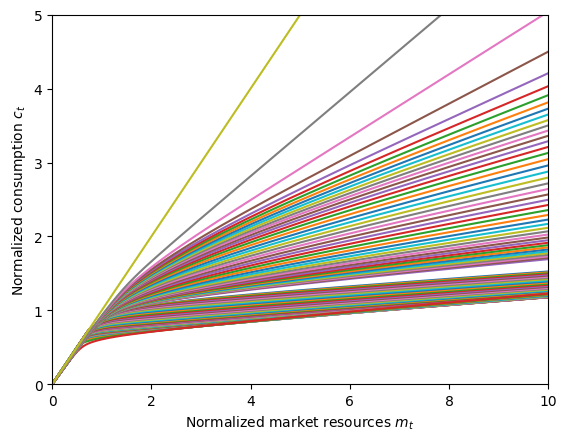

In [22]:
# Plot the consumption function at all ages
CalibratedType.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 5.0)
plot_funcs(CalibratedType.cFunc, 0.0, 10.0)